In [372]:
import os
import pandas as pd
import numpy as np
import datetime as dt
%matplotlib inline
import matplotlib.pyplot as plt
#import seaborn
import holidays
import pickle
from math import radians, cos, sin, asin, sqrt 

In [148]:
us_holidays = holidays.UnitedStates()

In [ ]:
pwd = os.getcwd()

## Weather

In [2]:

os.chdir(pwd + '/201402_babs_open_data/')
weather02_df = pd.read_csv('201402_weather_data.csv')

In [3]:

os.chdir(pwd + '/201408_babs_open_data/')
weather08_df = pd.read_csv('201408_weather_data.csv')

In [4]:
# changing the name of the dataframe to be indentical to the other weather dataframe
weather08_df.columns = ['Date', 'Max_Temperature_F', 'Mean_Temperature_F', 'Min_TemperatureF',
       'Max_Dew_Point_F', 'MeanDew_Point_F', 'Min_Dewpoint_F', 'Max_Humidity',
       'Mean_Humidity ', 'Min_Humidity ', 'Max_Sea_Level_Pressure_In ',
       'Mean_Sea_Level_Pressure_In ', 'Min_Sea_Level_Pressure_In ',
       'Max_Visibility_Miles ', 'Mean_Visibility_Miles ',
       'Min_Visibility_Miles ', 'Max_Wind_Speed_MPH ','Mean_Wind_Speed_MPH ','Max_Gust_Speed_MPH', 'Precipitation_In ', 'Cloud_Cover ', 'Events',
       'Wind_Dir_Degrees', 'zip']

In [5]:
frames = [weather02_df, weather08_df]
weather_df = pd.concat(frames, ignore_index=True)


In [6]:
weather_df['day'] = weather_df['Date'].apply(lambda x:pd.to_datetime(x))

In [17]:
landmark_dict = {94107:'San Francisco',
                 94063:'Redwood City',
                 94301:'Palo Alto', 
                 94041:'Mountain View', 
                 95113:'San Jose'}
weather_df['landmark'] = weather_df['zip'].map(lambda x: landmark_dict[x])

In [ ]:
weather_df['Precipitation_In '] = weather_df['Precipitation_In '].convert_objects(convert_numeric=True)

In [138]:
os.chdir(pwd)
with open('weather_df.pickle', 'wb') as handle:
    pickle.dump(weather_df, handle)


# checking if there are outliers in the dataset
only checking for upper outliers of max measurements, and lower for min measurements

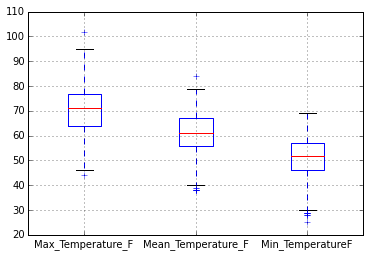

In [9]:
# 38C (102F) is extreme hot, so this day in this city will be deleted 
# tempreture 0c (32F) looks to be also outliers
weather_df.boxplot(['Max_Temperature_F','Mean_Temperature_F', 'Min_TemperatureF'], return_type='axes')

In [271]:
weather_df['Max_Temperature_F'].max(), weather_df['Min_TemperatureF'].quantile(0.01)

(102, 32.0)

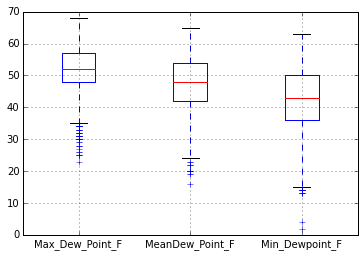

In [10]:
# dew is only uncomfortable when too high. As there are only low outliers in the dataset those won't be deleted
weather_df.boxplot(['Max_Dew_Point_F', 'MeanDew_Point_F', 'Min_Dewpoint_F'], return_type='axes')

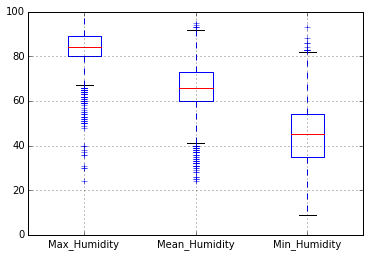

In [11]:
# no upper outliers of max measurements, and lower for min measurements
weather_df.boxplot(['Max_Humidity', 'Mean_Humidity ', 'Min_Humidity '], return_type='axes')

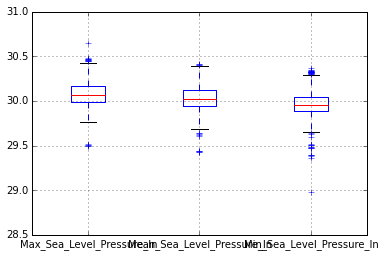

In [12]:
# as not even the outliers in sea level pressure should cause human discomfort no days will be removed
weather_df.boxplot([ 'Max_Sea_Level_Pressure_In ','Mean_Sea_Level_Pressure_In ', 'Min_Sea_Level_Pressure_In '], return_type='axes')

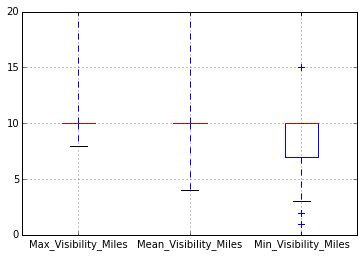

In [13]:
# visibility under 1 miles looks like extremely low in that area, so those days will be removed
weather_df.boxplot([ 'Max_Visibility_Miles ', 'Mean_Visibility_Miles ','Min_Visibility_Miles '], return_type='axes')

In [78]:
weather_df['Min_Visibility_Miles '].quantile(.02)

1.0

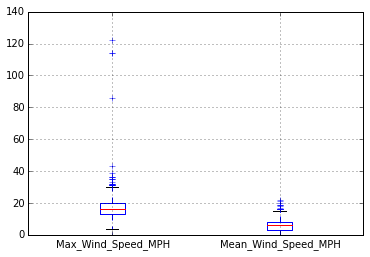

In [8]:
# wind speed above 31 MPH (50 kph) looks like extremely high in that area, so those days will be removed 
weather_df.boxplot([ 'Max_Wind_Speed_MPH ','Mean_Wind_Speed_MPH '], return_type='axes')

In [76]:
weather_df['Max_Wind_Speed_MPH '].quantile(.99)

31.0

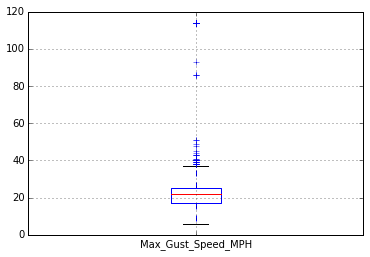

In [81]:
# gust speed above 38 MPH (61 kph) looks like extremely low in that area, so those days will be removed 
# (probably most of these days will be the same as the wind speed outliers)
weather_df.boxplot(['Max_Gust_Speed_MPH'], return_type='axes')

In [87]:
weather_df['Max_Gust_Speed_MPH'].quantile(.97)

38.0

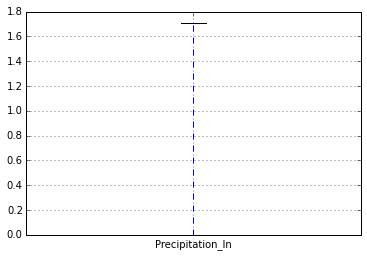

In [123]:
# it looks like there are no outliers
weather_df.boxplot(['Precipitation_In '], return_type='axes')

In [272]:
weather_df['Precipitation_In '].describe()

count    1776.000000
mean        0.015856
std         0.095413
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.710000
Name: Precipitation_In , dtype: float64

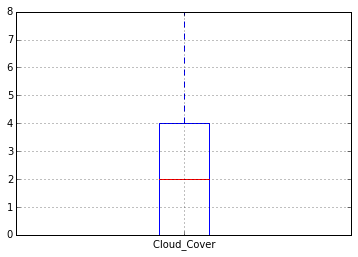

In [129]:
# it looks like there are no outliers
weather_df.boxplot(['Cloud_Cover '], return_type='axes')

## Status

In [139]:

os.chdir(pwd + '/201402_babs_open_data/')
status02_df = pd.read_csv('201402_status_data.csv')

In [140]:

os.chdir(pwd + '/201408_babs_open_data/')
status08_df = pd.read_csv('201408_status_data.csv')

In [141]:
frames = [status02_df, status08_df]
status_df = pd.concat(frames, ignore_index=True)

In [142]:
# selecting the date part of the time to be the base of grouping
status_df['day'] = status_df.time.str[:10]

In [143]:
# calculating the minimum amount of bikes and docks avaliable by day
stations_min = status_df.groupby([status_df.day, status_df.station_id]).min()

In [145]:
# getting rid of the multiindexing for easier merging 
stations_min.drop('station_id', axis=1, inplace=True)
stations_min.drop('day', axis=1, inplace=True)
stations_min = stations_min.reset_index()

In [147]:
stations_min['day'] = stations_min['day'].apply(lambda x:pd.to_datetime(x))

In [149]:
stations_min['is_holiday'] = stations_min.day.map(lambda x: x in us_holidays or x.weekday() > 5)

In [150]:
os.chdir(pwd)
with open('stations_min.pickle', 'wb') as handle:
    pickle.dump(stations_min, handle)

## Stations

In [151]:
# only using the later dataset for this as the stations are the same (or less) during the year
os.chdir(pwd + '/201408_babs_open_data/')
station_df = pd.read_csv('201408_station_data.csv')

In [273]:
station_df.shape

(70, 7)

## Trips

In [164]:

os.chdir(pwd + '/201402_babs_open_data/')
trip02_df = pd.read_csv('201402_trip_data.csv')

In [165]:

os.chdir(pwd + '/201408_babs_open_data/')
trip08_df = pd.read_csv('201408_trip_data.csv')

In [345]:
frames = [trip02_df, trip08_df]
trip_df = pd.concat(frames, ignore_index=True)

In [347]:
trip_df['Subscriber Type'].fillna(trip_df['Subscription Type'], inplace=True)
trip_df.drop('Subscription Type', axis=1, inplace=True)

In [348]:
trip_df['Start Date'] = trip_df['Start Date'].apply(lambda x:pd.to_datetime(x))
trip_df['End Date'] = trip_df['End Date'].apply(lambda x:pd.to_datetime(x))
trip_df.rename(columns={'Start Date': 'start_date', 'End Date': 'end_date'}, inplace=True)

In [349]:
trip_df['is_holiday'] = trip_df.start_date.map(lambda x: x in us_holidays or x.weekday() > 5)

In [350]:
# Monday=0, Sunday=6
trip_df['day_of_week'] = trip_df.start_date.dt.dayofweek

In [282]:
# function for calculating distance in km-s
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

In [328]:
def apply_havesine(series, station_df):
    lon1 = station_df[station_df['name'] == series[0]].long
    lat1 = station_df[station_df['name'] == series[0]].lat
    lon2 = station_df[station_df['name'] == series[1]].long
    lat2 = station_df[station_df['name'] == series[1]].lat
    return haversine(lon1, lat1, lon2, lat2)

In [352]:
# creating columns in station_df to be merged by these
station_df['Start Station'] = station_df['name']
station_df['End Station'] = station_df['name']

In [355]:
# adding start station coordianates to trip_df
trip_df = pd.merge(trip_df, station_df[['Start Station', 'landmark', 'dockcount', 'lat', 'long']], on='Start Station', how='left')
 trip_df.rename(columns = {'lat':'start_lat', 'long':'start_lon'}, inplace = True)                  

In [359]:
# adding end station coordianates to trip_df
trip_df = pd.merge(trip_df, station_df[['End Station', 'lat', 'long']], on='End Station', how='left')
trip_df.rename(columns = {'lat':'end_lat', 'long':'end_lon'}, inplace = True)

In [371]:
# calculating the distance
trip_df['end_lat_rad'], trip_df['end_lon_rad'] = np.radians(trip_df['end_lat']), np.radians(trip_df['end_lon'])
trip_df['start_lat_rad'], trip_df['start_lon_rad'] = np.radians(trip_df['start_lat']), np.radians(trip_df['start_lon'])
trip_df['dLON'] = trip_df['start_lon_rad'] - trip_df['end_lon_rad']
trip_df['dLAT'] = trip_df['start_lat_rad'] - trip_df['end_lat_rad']

TypeError: cannot convert the series to <class 'float'>

In [387]:
# some numpy transformation can't be performed on series at once because they require type float arguments. 
# while the pandas series can't be transformed to float type, but the elemnts one by one fulfill this requirement

trip_df['a1'] = trip_df['dLAT'].apply(lambda x: sin(x/2)**2)
trip_df['a2'] = trip_df['end_lat_rad'].apply(lambda x: cos(x))
trip_df['a3'] = trip_df['start_lat_rad'].apply(lambda x: cos(x))
trip_df['a4'] = trip_df['dLON'].apply(lambda x: sin(x/2)**2)

In [390]:
# using the Haversine formula
trip_df['a'] = trip_df['a1'] + trip_df['a2'] * trip_df['a3'] * trip_df['a4'] 
trip_df['distance'] = trip_df['a'].apply(lambda x: 6367 * 2 * asin(sqrt(x)))

In [395]:
trip_df['kph'] = trip_df['distance'] / (trip_df['Duration']/3600)

In [401]:
os.chdir(pwd)
with open('trip_df.pickle', 'wb') as handle:
    pickle.dump(trip_df, handle)

trips by station

In [209]:
# counting all the trips by station
trips_by_station = trip_df.groupby(trip_df['Start Terminal']).count()

In [210]:
trips_by_station = trips_by_station.reset_index()

In [211]:
trips_by_station = trips_by_station[['Start Terminal', 'Duration']]

In [212]:
trips_by_station.columns = ['station_id', 'trips_all_year']

In [213]:
trips_by_station.head()

,station_id,trips_all_year
0,2,4590
1,3,820
2,4,1903
3,5,695
4,6,1499


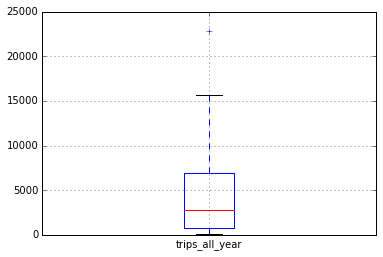

In [202]:
# one station is extremly popular
trips_by_station.boxplot(['trips_all_year'], return_type='axes')

In [214]:
trips_by_station[trips_by_station.trips_all_year>16000]

,station_id,trips_all_year
58,70,22788


In [197]:
station_df[station_df.station_id==70]

,station_id,name,lat,long,dockcount,landmark,installation
58,70,San Francisco Caltrain (Townsend at 4th),37.776617,-122.39526,19,San Francisco,8/23/2013


In [275]:
os.chdir(pwd)
with open('trips_by_stations.pickle', 'wb') as handle:
    pickle.dump(trips_by_station, handle)

## Merging the stations_min dataset

In [160]:
with open('stations_min.pickle', 'rb') as handle:
    stations_min = pickle.load(handle)

In [161]:
stations_min_merged = pd.merge(stations_min, station_df[['station_id', 'landmark', 'dockcount']], on='station_id', how='left')

In [162]:
stations_min_merged = pd.merge(stations_min_merged, weather_df, on=['day', 'landmark'], how='left')

In [215]:
stations_min_merged = pd.merge(stations_min_merged, trips_by_station, on=['station_id'], how='left')

removing rows with outlier weather conditions 

In [265]:
stations_min_filtered = stations_min_merged[(stations_min_merged['Max_Temperature_F']!=102)
                                            & (stations_min_merged['Min_TemperatureF']>32)
                                            & (stations_min_merged['Min_Visibility_Miles ']>1)
                                            & (stations_min_merged['Max_Wind_Speed_MPH ']<31)
                                            & (stations_min_merged['Max_Gust_Speed_MPH']<38)
                                            ]

In [266]:
stations_min_filtered.shape

(20532, 33)

In [268]:
os.chdir(pwd)
with open('stations_min_filtered.pickle', 'wb') as handle:
    pickle.dump(stations_min_filtered, handle)

In [218]:
os.chdir(pwd)
with open('stations_min_merged.pickle', 'wb') as handle:
    pickle.dump(stations_min, handle)